# Initialize the Database

In [1]:
'''
created by @asha
march 8th 2019
'''

'\ncreated by @asha\nmarch 8th 2019\n'

In [2]:
!mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

--2025-02-11 08:31:46--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 3.168.132.126, 3.168.132.7, 3.168.132.33, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|3.168.132.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G   245MB/s    in 23s     

2025-02-11 08:32:08 (176 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]



In [3]:
!pip install nuscenes-devkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 55.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.1/313.1 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.0 MB/s eta 0:00:00
  Created wheel for matplotlib: filename=matplotlib-3.5.3-cp311-cp311-linux_x86_64.whl size=11129100 sha256=8316f667424bf59ac7ddf02cceb01f1fe63019bb046adc14b19998a7c4e2e945
  Stored in directory: /root/.cache/pip/wheels/5d/3b/87/b850f835f7a97bd28b0fb81fd73bdb17755122ea5ad71484f9
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=f867622280e54c94999e43675896e3ce64f16158f1c7a60cf4b6bc657a8b9fde
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6

In [4]:
# Let's start by initializing the database
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import numpy as np


nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.695 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


Categories that are annotated

In [5]:
# The NuScenes class holds several tables. Each table is a list of records, and each record is a dictionary.
# For example the first record of the category table is stored at

#nusc.category[0]['name']

#these are the categories available
cat = []
for i in range(len(nusc.category)):
    print(nusc.category[i]['name'])
    cat.append(nusc.category[i]['name'])



human.pedestrian.adult
human.pedestrian.child
human.pedestrian.wheelchair
human.pedestrian.stroller
human.pedestrian.personal_mobility
human.pedestrian.police_officer
human.pedestrian.construction_worker
animal
vehicle.car
vehicle.motorcycle
vehicle.bicycle
vehicle.bus.bendy
vehicle.bus.rigid
vehicle.truck
vehicle.construction
vehicle.emergency.ambulance
vehicle.emergency.police
vehicle.trailer
movable_object.barrier
movable_object.trafficcone
movable_object.pushable_pullable
movable_object.debris
static_object.bicycle_rack


# classes that we are detecting :

We merge adult, child, police officer, construction worker into a single class called pedestrian
We are detecting:
- pedestrian
- car
- bicycle

In [6]:
classes = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker','vehicle.car','vehicle.bicycle']
pedestrians = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker']

In [7]:
print('Total number of samples')
print(len(nusc.sample))

total_no_of_samples = len(nusc.sample)

#print('Total number of images')
#print(len(nusc.sample*6)) #6 different cameras

Total number of samples
404


# Functions

Defined the following function:

- get_sample_data (edit of nutonomy's original nusc.get_sample_data)
        
        input:(nusc, sample_data_token)
        output:path to the data, lists of 3d bounding boxes in the image (in camera coordinates),
        annotation token of annotations in the image, intrinsic matrix of the camera)
        

- threeD_to_2D
         
        input: (box (camera coordinates),intrinsic matrix))
        output : corners of the 2d bounding box in image plane

- all_3d_to_2d(boxes,anns,intrinsic)

        input : boxes in camera coordinates, list of annotation tokens of annotations in the image,
        intrinsic matrix
        output: x_min,x_max,y_min,y_max,width,height of the 2D boundings boxes of objects that are
        more than 40% visible in panoramic view of all cameras, also ensures that the center of the
        bounding boxes falls inside the image

- extract_bounding_box(i):
        
        input: sample number
        output: min x, max x, min y max y, width and height of bounding box in image coordinates
        2d bounding box of objects which are 40% visible in panoramic view of all cameras and center
        falls witin the image



In [9]:
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import quaternion_slerp, box_in_image, BoxVisibility
import numpy as np

#from pyquaternion import Quaternion
#from nuscenes.utils.data_classes import Box
#from nuscenes.utils.geometry_utils import box_in_image, BoxVisibility, transform_matrix # import transform_matrix instead of quaternion_slerp
#import numpy as np
def get_sample_data(nusc_object, sample_data_token, box_vis_level=BoxVisibility.ANY, selected_anntokens=None):
    """
    Returns the data path as well as all annotations related to that sample_data(single image).
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: <str>. Sample_data token(image token).
    :param box_vis_level: <BoxVisibility>. If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: [<str>]. If provided only return the selected annotation.
    :return: (data_path <str>, boxes [<Box>], camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc_object.get('sample_data', sample_data_token)
    cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc_object.get('sensor', cs_record['sensor_token'])
    pose_record = nusc_object.get('ego_pose', sd_record['ego_pose_token'])

    sample_record = nusc_object.get('sample',sd_record['sample_token'])
    data_path = nusc_object.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc_object.get_box, selected_anntokens))
    else:
        boxes = nusc_object.get_boxes(sample_data_token)
        selected_anntokens = sample_record['anns']

    # Make list of Box objects including coord system transforms.
    box_list = []
    ann_list = []
    for box,ann in zip(boxes,selected_anntokens):

        # Move box to ego vehicle coord system
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)
        ann_list.append(ann)
    #this is for a single sample image
    return data_path, box_list, ann_list, cam_intrinsic #single image inf

In [12]:
def threeD_2_twoD(boxsy,intrinsic): #input is a single annotation box
    '''
    given annotation boxes and intrinsic camera matrix
    outputs the 2d bounding box coordinates as a list (all annotations for a particular sample image)
    '''
    corners = boxsy.corners()
    x = corners[0,:]
    y = corners[1,:]
    z = corners[2,:]
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(intrinsic,x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    perspective_z = orthographic[2]/orthographic[2]

    min_x = np.min(perspective_x)
    max_x = np.max(perspective_x)
    min_y = np.min(perspective_y)
    max_y = np.max(perspective_y)



    return min_x,max_x,min_y,max_y



def all_3d_to_2d(boxes,anns,intrinsic): #input 3d boxes, annotation key lists, intrinsic matrix (one image)
    x_min=[]
    x_max=[]
    y_min=[]
    y_max =[]
    width=[]
    height=[]
    objects_detected =[]
    orig_objects_detected =[]


    for j in range(len(boxes)): #iterate through boxes
        box=boxes[j]

        if box.name in classes: #if the box.name is in the classes we want to detect

            if box.name in pedestrians:
                orig_objects_detected.append("pedestrian")
            elif box.name == "vehicle.car":
                orig_objects_detected.append("car")
            else:
                orig_objects_detected.append("cyclist")
            #print(box)

            visibility = nusc.get('sample_annotation', '%s' %anns[j])['visibility_token'] #give annotation key
            visibility = int(visibility)


            if visibility > 1: #more than 40% visible in the panoramic view of the the cameras


                center = box.center #get boxe's center

                center = np.dot(intrinsic,center)
                center_point = center/(center[2]) #convert center point into image plane




                if center_point[0] <-100 or center_point[0] > 1700 or center_point[1] <-100 or center_point[1] >1000:
                    #if center of bounding box is outside of the image, do not annotate
                    pass

                else:
                    min_x, max_x, min_y, max_y = threeD_2_twoD(box,intrinsic) #converts box into image plane
                    w = max_x - min_x
                    h = max_y - min_y


                    x_min.append(min_x)
                    x_max.append(max_x)
                    y_min.append(min_y)
                    y_max.append(max_y)
                    width.append(w)
                    height.append(h)
                    if box.name in pedestrians:
                        objects_detected.append("pedestrian")
                    elif box.name == "vehicle.car":
                        objects_detected.append("car")
                    else:
                        objects_detected.append("cyclist")


            else:
                pass

    return x_min,x_max,y_min,y_max,width,height,objects_detected,orig_objects_detected #for a single image

In [13]:
def extract_bounding_box(i,camera_name): #give a single sample number and camera name

    '''
    input sample number i, camera name
    outputs min x, max x, min y max y, width and height of bounding box in image coordinates
    2d bounding box
    options for camera name : CAM_FRONT, CAM_FRONT_RIGHT, CAM_FRONT_LEFT, CAM_BACK, CAM_BACK_RIGHT,CAM_BACK_LEFT
    '''

    nusc.sample[i] #one image

    camera_token = nusc.sample[i]['data']['%s' %camera_name] #one camera, get the camera token

    path, boxes, anns, intrinsic_matrix = get_sample_data(nusc,'%s' %camera_token) #gets data for one image

    x_min, x_max,y_min,y_max,width,height, objects_detected,orig_objects_detected = all_3d_to_2d(boxes,anns, intrinsic_matrix)

    return x_min, x_max, y_min, y_max, width, height, path, boxes,intrinsic_matrix, objects_detected,orig_objects_detected
    #info for a single image


In [14]:
#Create target Directory if don't exist
import os.path
def create_annotation_directory(camera):
    current_dir =os.getcwd()
    #current_dir ="%s/annotation" %pwd
    dirName ="%s/annotation/%s_anno" %(current_dir,camera)
    if not os.path.exists(dirName):
        os.makedirs(dirName)
        print("Directory " , dirName ,  " Created ")
    else:
        print("Directory " , dirName ,  " already exists")

In [15]:
from lxml import etree as ET
def write_xml_annotation(x_min,x_max,y_min,y_max,width,height,path,boxes,objects_detected): #single image info
    #detected_items =[]
    #import xml.etree.cElementTree as ET
    path_split = path.split("/")
    full_image_name = path_split[-1]
    name =full_image_name.split(".")[0]

    root = ET.Element("annotation")


    ET.SubElement(root, "folder").text = "%s" %camera
    ET.SubElement(root, "filename").text = "%s" %full_image_name
    ET.SubElement(root, "path").text = "%s" %path

    source = ET.SubElement(root, "source")
    ET.SubElement(source, "database").text = "nuTonomy-nuscenes"

    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text="1600"
    ET.SubElement(size,"height").text="900"
    ET.SubElement(size,"depth").text="3"
    ET.SubElement(root, "segmented").text = "0"

    for j in range(len(objects_detected)): #

        flag_x = 0
        flag_y = 0

        ob= ET.SubElement(root, "object")
        ET.SubElement(ob,"name").text="%s" %objects_detected[j]
        ET.SubElement(ob,"pose").text="Unspecified"


        '''
        write out truncated boxes
        '''

        if x_min[j] < 0:
            x_minsy = 0
            flag_x =1

        else:
            x_minsy = x_min[j]

        if y_min[j] <0:
            y_minsy = 0
            flag_y =1

        else:
            y_minsy = y_min[j]

        if x_max[j] > 1600:
            x_maxsy = 1600
            flag_x = 1

        else:
            x_maxsy = x_max[j]

        if y_max[j] >900:
            y_maxsy = 900
            flag_y = 1

        else:
            y_maxsy = y_max[j]


        if flag_x == 1 or flag_y ==1:
            ET.SubElement(ob, "truncated").text="1"

        else:
            ET.SubElement(ob, "truncated").text="0"




        ET.SubElement(ob, "difficult").text="0"

        bb = ET.SubElement(ob,"bndbox")


        ET.SubElement(bb,"xmin").text="%s" %x_minsy
        ET.SubElement(bb,"ymin").text="%s" %y_minsy
        ET.SubElement(bb,"xmax").text="%s" %x_maxsy
        ET.SubElement(bb,"ymax").text="%s" %y_maxsy


    filename = "%s/%s.xml" %(dirName,name)
    tree = ET.ElementTree(root)
    #tree.write("%s/%s.xml" %(dirName,name),pretty_print=True)
    tree.write("%s" %filename, pretty_print=True)

    return filename #file a single file


In [16]:
camera_names =['CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_FRONT_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT', 'CAM_BACK_LEFT']

i = 0
detected_items =[]
orig_detected_items=[]
obs = []

file=[]

for camera in camera_names: #iterate through all cameras
    print(camera)
    create_annotation_directory(camera)
    current_dir =os.getcwd()
    dirName ="%s/annotation/%s_anno" %(current_dir,camera) #current directory's name
    #we are looking at one camera now
    for sample_number in range(total_no_of_samples):#look at a single image
        #print(sample_number)
        #get in for a single image




        x_min, x_max,y_min,y_max,width,height, path, boxes, intrinsic_matrix,objects_detected,orig_objects_detected = extract_bounding_box(sample_number, '%s' %camera)
        write_xml_annotation(x_min,x_max,y_min,y_max,width,height,path,boxes,objects_detected)





CAM_FRONT
Directory  /content/annotation/CAM_FRONT_anno  Created 
CAM_FRONT_RIGHT
Directory  /content/annotation/CAM_FRONT_RIGHT_anno  Created 
CAM_FRONT_LEFT
Directory  /content/annotation/CAM_FRONT_LEFT_anno  Created 
CAM_BACK
Directory  /content/annotation/CAM_BACK_anno  Created 
CAM_BACK_RIGHT
Directory  /content/annotation/CAM_BACK_RIGHT_anno  Created 
CAM_BACK_LEFT
Directory  /content/annotation/CAM_BACK_LEFT_anno  Created 


In [17]:
print(len(obs))
print(len(orig_detected_items))

print(len(file))

unique = list(set(file))
print(len(unique))

print('total number of files')
3962*6

0
0
0
0
total number of files


23772

In [18]:
print(len(file))
#print(len(unique))

for i in range(len(file)):
    check = file[i]

    for j in range(len(file)):
        if j !=i :
            if check == file[j]:
                print(i)
                print(j)
                print('katie')

0


In [25]:
import os.path
from os import listdir
import xml.etree.ElementTree as ET
camera_names =['CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_FRONT_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT', 'CAM_BACK_LEFT']

def list_of_files(camera):
    current_dir =os.getcwd()
    #current_dir ="%s/annotation" %pwd

    dirName ="%s/annotation/%s_anno" %(current_dir,camera)
    files = os.listdir(dirName)

    return files, dirName, current_dir

In [26]:
total_objects_detected =[]
for camera in camera_names:
    files, dirName,current_dir = list_of_files(camera)
    print(dirName)

    for f in files:
        name_of_file = '%s/%s' %(dirName, f)
        #print(name_of_file)
        w,h,od = extract_data(name_of_file,dirName)
        total_objects_detected = total_objects_detected + od
        #print(od)
        #print(od)


/content/annotation/CAM_FRONT_anno
/content/annotation/CAM_FRONT_RIGHT_anno
/content/annotation/CAM_FRONT_LEFT_anno
/content/annotation/CAM_BACK_anno
/content/annotation/CAM_BACK_RIGHT_anno
/content/annotation/CAM_BACK_LEFT_anno


In [27]:
print(len(total_objects_detected))
print(len(detected_items))

10025
0


In [28]:
print(orig_detected_items.count('car'))
print(orig_detected_items.count('pedestrian'))
print(orig_detected_items.count('cyclist'))


add = orig_detected_items.count('car') + orig_detected_items.count('pedestrian') + orig_detected_items.count('cyclist')
print(add)

0
0
0
0


In [29]:
import os
print(os.getcwd())

/content


In [30]:
#print(len(detected_items))
print('Total number of car annotations:')
print(detected_items.count('car'))
print('Total number of pedestrian annotations')
print(detected_items.count('pedestrian'))
print('Total number of cyclist annotations')
print(detected_items.count('cyclist'))

add = detected_items.count('car') + detected_items.count('pedestrian') + detected_items.count('cyclist')
print(add)

Total number of car annotations:
0
Total number of pedestrian annotations
0
Total number of cyclist annotations
0
0


In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

im = np.array(Image.open('/Volumes/Luthor/nutonomy/nuscenes-devkit-master/python-sdk/%s' %path), dtype=np.uint8)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
# Create figure and axes


# Display the image
ax.imshow(im)
#

#print(x)
#print(y)
#print(width)
#print(height)
#print(center_point[0])
#print(center_point[1])

#width = max_x-min_x
#height = max_y-min_y
#for i in range(len(perspective_x)):
#ax.plot(center_point[0], center_point[1], marker ='o', color='b', markersize =30)
#ax.plot(perspective_x[i], perspective_y[i], marker ='o', color='b', markersize =10)
#ax.plot(r2c2[0], r2c2[1], marker ='o', color='b', markersize =10)
#ax.plot(min_x, min_y, marker ='o', color='b', markersize =10)
#ax.plot(max_x, max_y, marker ='o', color='b', markersize =10)

for i in range(len(x_min)):
    if objects_detected[i] =='pedestrian':
        col = 'red'
    elif objects_detected[i] =='car':
        col ='green'
    else:
        col= 'blue'
    rect = patches.Rectangle((x_min[i],y_min[i]),width[i],height[i],linewidth=2,edgecolor='%s' %col,facecolor='none')
#ax.plot(k3[0], k3[1], marker ='o', color='b', markersize =10)
#ax.plot(k4[0], k4[1], marker ='o', color='b', markersize =10)
#ax.plot(k5[0], k5[1], marker ='o', color='b', markersize =10)
#ax.plot(k6[0], k6[1], marker ='o', color='b', markersize =10)
#ax.plot(k7[0], k7[1], marker ='o', color='b', markersize =10)
#ax.plot(k8[0], k8[1], marker ='o', color='b', markersize =10)

#rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='blue',facecolor='none')

# Add the patch to the Axes
    ax.add_patch(rect)
plt.savefig('foo.jpeg')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Luthor/nutonomy/nuscenes-devkit-master/python-sdk//data/sets/nuscenes/samples/CAM_BACK_LEFT/n015-2018-11-21-19-38-26+0800__CAM_BACK_LEFT__1542801007447423.jpg'

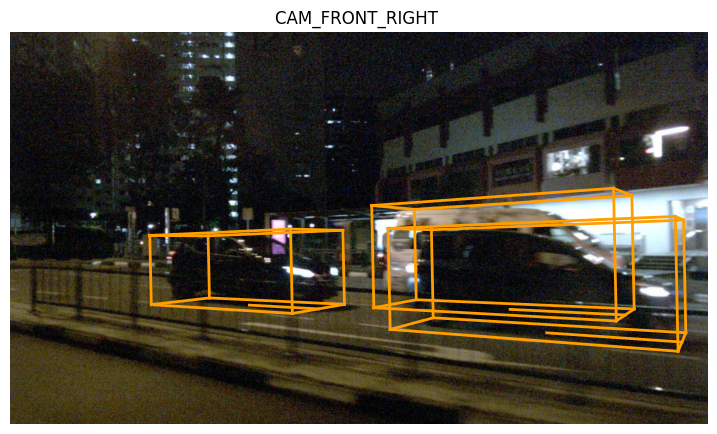

{'token': 'a84f43c4ef52461d940a6c7d0768b86f', 'timestamp': 1542800859947349, 'prev': '273c930b3f384bd58b2bbae02fe81d1e', 'next': '8d7dcd1533704f5882a5afcb65509ed5', 'scene_token': 'de7d80a1f5fb4c3e82ce8a4f213b450a', 'data': {'RADAR_FRONT': '6954819f87ae4a89b7012ce9de4242b8', 'RADAR_FRONT_LEFT': 'aedd82eabb824be6b515911189359a59', 'RADAR_FRONT_RIGHT': '48f9e13bdaaa4ee491de0ba9f1e4e32a', 'RADAR_BACK_LEFT': '81c2a6d7e1344160a19e1d55a3d8c8c1', 'RADAR_BACK_RIGHT': '0caddc48852c46cea323aea854b04e25', 'LIDAR_TOP': 'b30f1f4f6ad4440fa0cf59cced0f2ad9', 'CAM_FRONT': 'ffa9bd002e7f47ec93caaa9f45fa03e6', 'CAM_FRONT_RIGHT': '2e5cb9189d204bba80af4f06c42188d5', 'CAM_BACK_RIGHT': 'f8c49956f213485188ce30a6f1409188', 'CAM_BACK': 'c10b392b640a434dab1ae145adb8639b', 'CAM_BACK_LEFT': '9752692495674ac0a7240589cf2dea17', 'CAM_FRONT_LEFT': 'ac837afa590f462e94f2a4e1e0cd9fa7'}, 'anns': ['28e64960f6fd4e639b1c5606ba5df184', 'a5cf7cf6355546c989c74a6d8d6bf72f', '77a8b98bef814d1cb9166c0d969d9b25', 'a5d00fc0bb3b4b2392e

KeyError: 'bde261e2ea904fcd86cef6e007bdfdb4'

In [34]:
#3d render with original bounding boxes
#343
#369

#383
#357
sample_number =348
camera = 'CAM_FRONT_RIGHT'
my_sample = nusc.sample[sample_number]
nusc.render_sample_data(my_sample['data']['%s' %camera])
print(my_sample)
print('this is the path')

nusc.get('sample_data', 'bde261e2ea904fcd86cef6e007bdfdb4')


f1= 'samples/CAM_FRONT_RIGHT/n008-2018-05-21-11-06-59-0400__CAM_FRONT_RIGHT__1526915624869956.jpg'
f2 ='samples/CAM_FRONT_RIGHT/n008-2018-05-21-11-06-59-0400__CAM_FRONT_RIGHT__1526915624869956.jpg'

if f1 ==f2:
    print('katie')

In [ ]:
sample_number =374
camera = 'CAM_FRONT_RIGHT'
my_sample = nusc.sample[sample_number]
nusc.render_sample_data(my_sample['data']['%s' %camera])
print(my_sample)

#'5eedbe17cf2f44e2829567eeeb12f569'

print('this is the path')

nusc.get('sample_data', '2cab2f94315e47eea4e4409d7906db6b')



In [ ]:
#import xml.etree.cElementTree as ET
from lxml import etree as ET
root = ET.Element("annotation")


ET.SubElement(root, "folder").text = "captures_vlc"
ET.SubElement(root, "filename").text = "katie.jpg"
ET.SubElement(root, "path").text = "katie.jpg"

source = ET.SubElement(root, "source")
ET.SubElement(source, "database").text = "nuTonomy-nuscenes"

size = ET.SubElement(root, "size")
ET.SubElement(size, "width").text="Katie"
ET.SubElement(size,"height").text="Kates"
ET.SubElement(size,"depth").text="KM"
ET.SubElement(root, "segmented").text = "0"

ob= ET.SubElement(root, "object")
ET.SubElement(ob,"name").text="ball"
ET.SubElement(ob,"pose").text="Unspecified"
ET.SubElement(ob, "truncated").text="truncated"
ET.SubElement(ob, "difficult").text="0"

bb = ET.SubElement(ob,"bndbox")
ET.SubElement(bb,"xmin").text="xmin"
ET.SubElement(bb,"ymin").text="ymin"
ET.SubElement(bb,"xmax").text="xmax"
ET.SubElement(bb,"ymax").text="ymax"


tree = ET.ElementTree(root)
tree.write("%s.xml" %name,pretty_print=True)

In [ ]:
i = 0
with open('images_with_no_annotations.txt') as f:
    for line in f:
        #print(line)

        i = i +1

In [ ]:
print(i)